# STM R

Dans ce deuxieme lab, nous allons reprendre le corpus de l'est republicain mais avec le package STM en R.

Meme dataset que pour le lab 01

Pourquoi le package STM en R?

http://www.structuraltopicmodel.com/

* Facile à utiliser
* Beaucoup de fonctionnalités: preparation du corpus, visualization, ...
* Nombre de topics suggérés et analysable


# Le code R :

1. Chargement du dataset dans une dataframe
2. Nettoyage du code
3. Filtrage des mots en fonction de leur fréquence
4. STM / LDA
5. Résultats
6. Bonheur / Bliss 



In [1]:
# set working directory
setwd("~/amcp/upem/UPEM-NUMI/lab02/notebooks/")

# Chargement des packages
source('initialize.R')

# initialisation des parametres de l'experience
source('config.R')


stm v1.3.0 (2017-09-08) successfully loaded. See ?stm for help.
Loading required package: RColorBrewer

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: magic
Loading required package: abind

Attaching package: ‘data.table’

The following object is masked from ‘package:magic’:

    shift




[09:49:18] Config loaded: 
	experiment: 01
	on source: estrepublicain_annee_1999.csv 


In [3]:
# ------------------------------------------------------------------------------
#  Load data
# ------------------------------------------------------------------------------
qqcat("Load data from @{s.input_file}")

# Chargement du corpus dans une dataframe
df <- read.csv(s.input_file, nrows = s.max_rows, col.names = c(s.text_feature))

# combien de rows
qqcat("dimensions:")
dim(df)

# Vérifier le contenu
qqcat(" 2 premiers paragraphes")
df$text[0:2]





[09:49:54] Load data from /Users/alexis/amcp/upem/UPEM-NUMI/lab02/data/estrepublicain_annee_1999.csv
[09:49:55] dimensions:

[1] 5000    1


[09:49:56]  2 premiers paragraphes

[1] André Bauer, le Bonhomme de St-Dié ; Alain Dagosto, Bières de Vézelize (54) ; Paulette Gay, Pieds de cochons de Dommartin ; Corinne Dexemple, Tourte néocastrienne ; Bernadette Paulin, Pâté lorrain de Châtenois ; Andrée Labrux, Pétrou de Senones ; Marie-Thérèse Muller, Cochonneux de la Seille de Sillegny (57) ; Ginette Laporte, Eau de Contrexéville ; Danièle Richard, Framboise saulxuronne ; Josette Pouchucq, Cuisses de grenouilles de Vittel ; Daniel Léonard, Nostre damme de Chiney (Belgique) ; Sophie Valdenaire, Pissenlit de Xertigny ; Simone Leick, Cochon d'autrefois de Sierck les Bains (57) ; Yves Lievens, Kuulkappers de St-Gilles (Belgique) ; Brigitte Lievens, Miel de montagne de Plombières ; Louise Fallot, Madeleine de Commercy ; Claude Himbert, Macaron et bergamote de Nancy ; Robert Fuchs, Marmite d'or ; Jean-Pierre Ruspini, Saumon de Salm ; Jean-Marie Mougel, Andouille du Val d'Ajol ; Jean-François Ancel, Rognons blancs de Raon aux Bois ; Evelyne Bailleux, Fine coquille de Poseïdon de Recey sur Ource (21) ; Dominique Thaller, Tête de veau de Rambervillers ; Nicole Dubois, Boudin noir de Soissons (02) ; Martine Pattey, Image d'Epinal.
[2] Le Smash Entente Club de Lunéville (SECL) a repris ses activités au complexe Berte. Les séances d'entraînement du mercredi soir, de 20 h à 22 h, sont ouvertes à toute personne adulte désirant pratiquer le volley-ball dans un esprit de loisir et de détente. Pour ceux ou celles qui souhaitent participer au championnat loisir, un entraînement spécifique leur est proposé le lundi soir, aux mêmes horaires. L'assemblée générale du club aura lieu le mercredi 29 septembre, à 20 h, dans la salle de réunion de la maison des sports. Tous les membres du club y sont conviés ainsi que toutes les personnes intéressées. Pour tout renseignement complémentaire, s'adresser au président J. Ravaine (03.83.74.12.28).                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
5000 Levels: _ « Je protège toujours mon entraîneur et son staff. Nous sommes tous sur le même bateau et on doit ramer dans le même sens en compagnie des joueurs. Maintenant, vu les moyens engagés et les installations mises à disposition, je ne peux rien donner de plus. Il faut que le doute disparaisse, que le groupe se stabilise, prenne des points et se montre plus conquérant. Quant au recrutement d'un libero, nous n'avons pas trouvé l'élément susceptible de remplacer Jean-Guy Wallemme. Si les techniciens tombent d'accord sur un nom, je ne cracherai pas dessus. Mais j'estime que nous disposons pour la D2 d'un effectif suffisamment bien armé. Maintenant, je le répète, c'est aux joueurs d'aller chercher une victoire impérative face à Caen samedi ». ...

# Pre processing


Le package stm fait tout!


```processed``` contient

* ```processed$documents``` la matrice mots -documents
* ```processed$vocab``` la liste des mots


### Parametres

* lowercase
* removestopwords: utilise le snowball stemmer (meme que NLTK) cf: http://snowball.tartarus.org/algorithms/french/stop.txt
* ajouter des mots avec customstopwords
* stem: stemming transforme le mot en sa racine != lematization



In [4]:
# ------------------------------------------------------------------------------
# 1) pre process the text with basic NLP massaging
# ------------------------------------------------------------------------------
qqcat("pre processing\n")
processed <- textProcessor(df[,s.text_feature],
                           language         = "fr",
                           lowercase        = TRUE,
                           removestopwords  = TRUE,
                           customstopwords  = c('des'),
                           removenumbers    = TRUE,
                           removepunctuation = TRUE,
                           wordLengths      = c(s.min_wordlen,Inf),
                           striphtml        = TRUE,
                           stem             = FALSE,
                           verbose          = FALSE,
                           metadata         = df)
print(processed)





[09:50:01] pre processing
A text corpus with 5000 documents, and an 50731 word dictionary.


## Reduire le corpus

Exclure les mots trop frequents ou pas assez avec ```lower.thresh``` et ```upper.thresh```



In [5]:
out   <- prepDocuments(processed$documents,
                       processed$vocab,
                       processed$meta,
                       lower.thresh = s.thresh.lower,
                       upper.thresh = s.thresh.upper
                   )

docs  <- out$documents
vocab <- out$vocab
meta  <- out$meta


Removing 48108 of 50731 terms (130292 of 318298 tokens) due to frequency 
Your corpus now has 5000 documents, 2623 terms and 188006 tokens.

# Le topic model

On peut specifier un nombre de topic comme avec Gensim

Mais aussi laisser le modele trouver le nombre de topic optimal en donnant la valeur 0




In [6]:
qqcat("fit stm\n")

num_topics <- 0
fit <- stm(out$documents, out$vocab, 
           num_topics,
           reportevery = 10,
           max.em.its  = 100,
           emtol       = 1.5e-4,
           init.type   = "Spectral",
           seed        = 1
       )

# Sauver l'environnement
qqcat("stm done\n")
if (s.save_envt){
  qqcat("saving to @{s.envt_filename}")
  save.image(s.envt_filename)
}



[09:50:19] fit stm
Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Finding anchor words...
 	
	 Recovering initialization...
 	..........................
Initialization complete.
....................................................................................................
Completed E-Step (6 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -7.138) 
....................................................................................................
Completed E-Step (5 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -6.984, relative change = 2.155e-02) 
....................................................................................................
Completed E-Step (5 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -6.935, relative change = 6.989e-03) 
....................................................................................................
Completed E-

# Explorer les resultats

* plot(fit, labeltype=c("frex"), main = 'Topic Most Frequent Words',bty="n")



In [7]:
plotModels(fit, main='Model Selection - Best Likelihood')

ERROR: Error in plotModels(fit, main = "Model Selection - Best Likelihood"): plotModels only works for selectModel objects


Warning message in text.default(frequency[invrank[i]] + min(2 * max(frequency), :
“conversion failure on 'Topic 2: exposition, lexposition, lart, œuvres, artistes, art, lartiste, peinture, culture, arts' in 'mbcsToSbcs': dot substituted for <c5>”Warning message in text.default(frequency[invrank[i]] + min(2 * max(frequency), :
“conversion failure on 'Topic 2: exposition, lexposition, lart, œuvres, artistes, art, lartiste, peinture, culture, arts' in 'mbcsToSbcs': dot substituted for <93>”

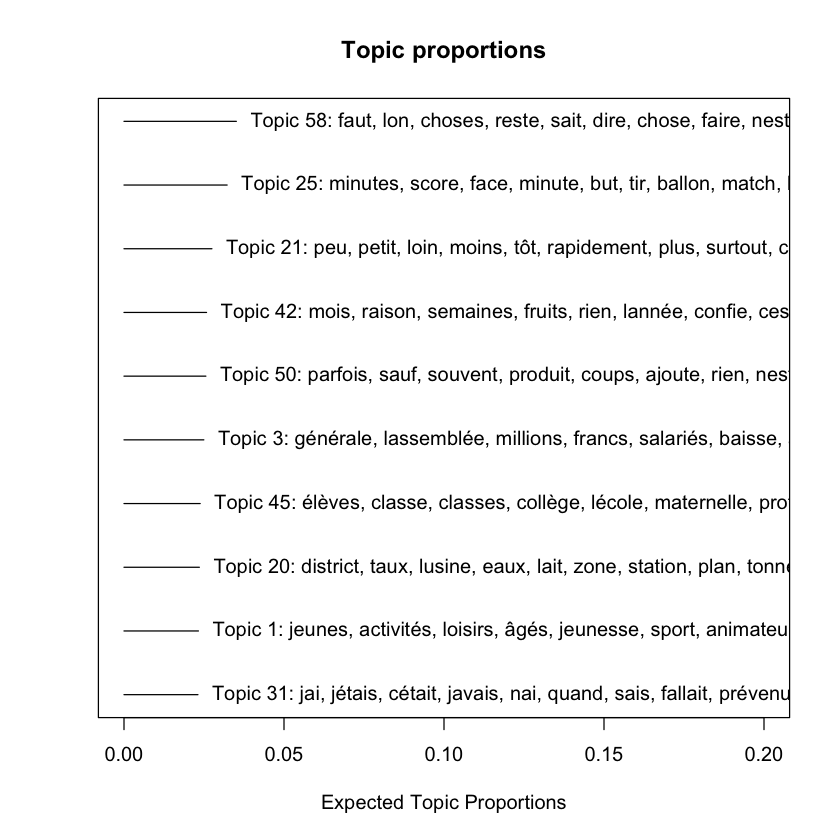

In [9]:
plot.STM(fit,type = "summary", labeltype= 'frex', main= 'Topic proportions', n = 10, xlim =c(0, 0.2), ylim=c(50,59))

In [ ]:
?plot.STM